In [ ]:
import os
import sys

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

In [2]:
import chromadb
import numpy as np
import io
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
load_dotenv(os.path.join(repo_dir,".env"))

In [3]:

from chromadb.api.types import is_image, is_document, Images,  Documents, EmbeddingFunction, Embeddings, Protocol
from typing import cast, Union, TypeVar

## chromadb multimodal

In [4]:
Embeddable = Union[Documents, Images]
D = TypeVar("D", bound=Embeddable, contravariant=True)

class ClipEmbbeding(EmbeddingFunction[D]):
    def __init__(self) -> None:
        pass
    def __call__(self, input: D) -> Embeddings:
        embeddings: Embeddings = []
        for item in input:     
            if is_document(item):
                #TODO implement SN endpoint inference
                output = None
            elif is_image(item):
                image = Image.fromarray(item)
                buffer = io.BytesIO()
                image.save(buffer, format='PNG')
                buffer
                #TODO implement SN endpoint inference
                output = None
            embeddings.append(output["embedding"])
        return cast(Embeddings, embeddings)


In [6]:
client = chromadb.PersistentClient(path=os.path.join(kit_dir,"data"))
clip_embedding=ClipEmbbeding()
try:
    client.delete_collection(name="image_collection")
except:
    pass
collection=client.get_or_create_collection(name="image_collection", embedding_function=clip_embedding, metadata={"hnsw:space": "l2"})
collection.get()


{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

In [7]:
def get_images(folder_path):
    images=[]
    paths=[]
    for root, _dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                path=os.path.join(root, file)
                paths.append(path)
                image= np.array(Image.open(os.path.join(root, file)))
                images.append(image)
    return paths,images

In [8]:
paths, images=get_images(os.path.join(kit_dir,"data/images"))
print(len(paths))

400


## Add individual images 

In [10]:
collection.add(
    images=images,
    metadatas=[{"source": path} for path in paths],
    ids=paths,
    uris=paths
)

In [76]:
collection.get()#include=["uris","documents"])

{'ids': ['../images/animals/animals_0.png',
  '../images/animals/animals_1.png',
  '../images/animals/animals_10.png',
  '../images/animals/animals_11.png',
  '../images/animals/animals_12.png',
  '../images/animals/animals_13.png',
  '../images/animals/animals_14.png',
  '../images/animals/animals_15.png',
  '../images/animals/animals_16.png',
  '../images/animals/animals_17.png',
  '../images/animals/animals_18.png',
  '../images/animals/animals_19.png',
  '../images/animals/animals_2.png',
  '../images/animals/animals_20.png',
  '../images/animals/animals_21.png',
  '../images/animals/animals_22.png',
  '../images/animals/animals_23.png',
  '../images/animals/animals_24.png',
  '../images/animals/animals_25.png',
  '../images/animals/animals_26.png',
  '../images/animals/animals_27.png',
  '../images/animals/animals_28.png',
  '../images/animals/animals_29.png',
  '../images/animals/animals_3.png',
  '../images/animals/animals_30.png',
  '../images/animals/animals_31.png',
  '../ima

## Search methods

In [52]:
def search_image_by_text(query,n=5):
    result=collection.query(query_texts=[query],include=["uris", "distances"],n_results=n)
    return result['uris'][0], result["distances"][0]

In [53]:
def search_image_by_image(path,n=5):
    image= np.array(Image.open(path))
    result=collection.query(query_images=[image],include=["uris", "distances"],n_results=n)
    return result['uris'][0], result["distances"][0]

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(image_paths, distances):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(10*num_images, 10))
    
    for i, path in enumerate(image_paths):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}, d={distances[i]}')
    
    plt.show()


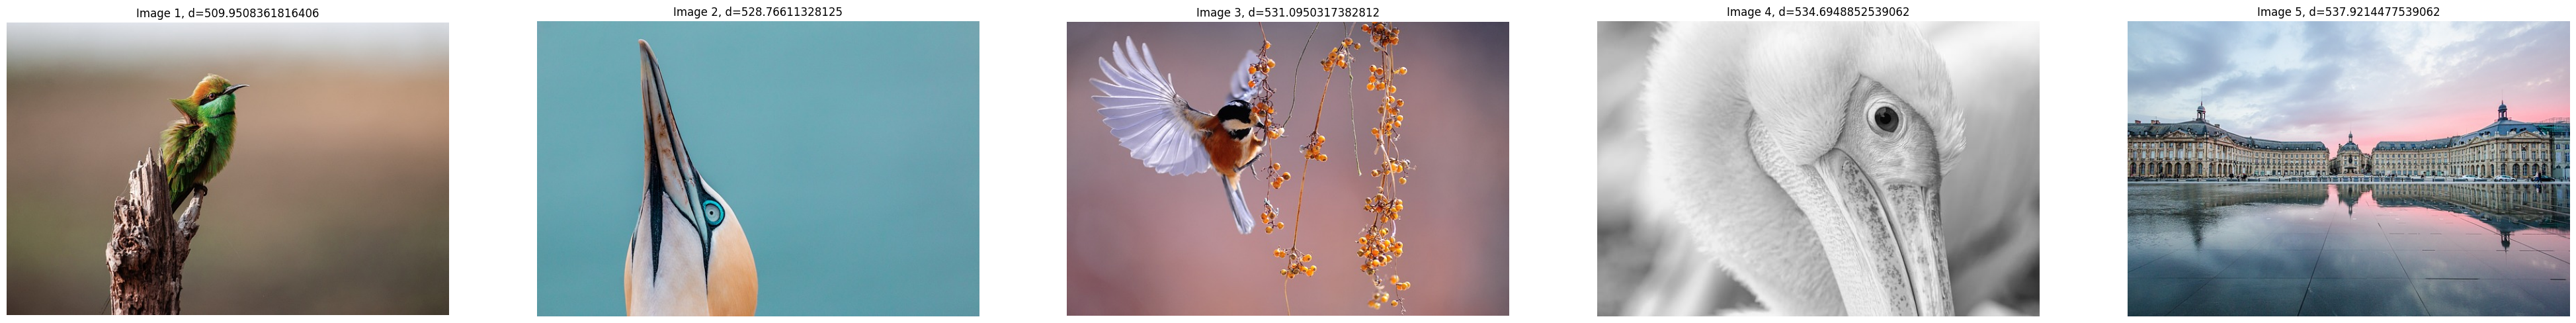

In [74]:
uris, distances = search_image_by_text("birds")
show_images(uris, distances)

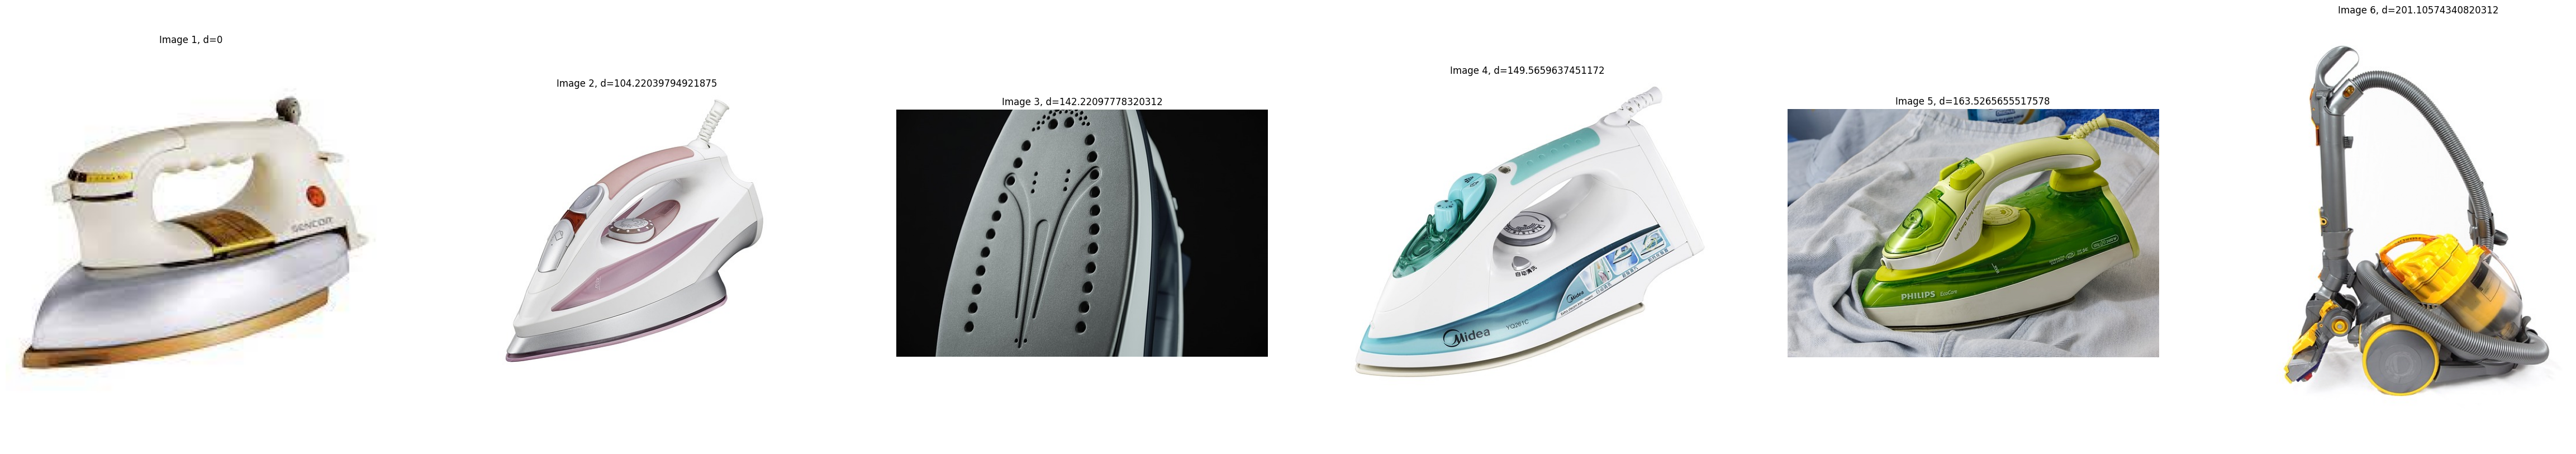

In [62]:
uris, distances = search_image_by_image("../download.jpeg")
uris.insert(0, "../download.jpeg")
distances.insert(0, 0)
show_images(uris, distances)

## Batch image ingestion

In [ ]:
# TO-DO WIP